In [1]:
import sqlite3
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable
from datetime import datetime, timedelta

In [2]:
# 백테스트 기간의 가격 정보를 가져온다.
df_price = marcap_data('2000-01-01', '2019-12-31')

In [3]:
# query financial statement data
conn = sqlite3.connect('../../data/data_v3.1.db')
cur = conn.cursor()

In [12]:
NUM_PORTFOLIO_STOCKS = 30 # 포트폴리오에 넣을 종목 수
LIQUID_RATE = 1.5 # 유동비율
MAX_MARKET_CAP = 0.2 # 시가총액 하위 기준
LOOKBACK_WINDOW = 60 # 과거 모멘텀을 계산하기 위한 기간 (일자 기준)

In [25]:
def get_finance_data(year):
    sql = "select * from fs where year=" + year
    cur.execute(sql)
    rows = cur.fetchall()
    
    # insert querried data into dataframe
    df_company = pd.DataFrame(columns=['날짜', '기업코드', '종목코드', '회사명', 
                                       '자산총계', '자본총계', '매출총이익', '유동자산', '유동부채', '당기순이익', '부채총계',
                                       '매출액(수익)', '영업활동으로인한현금흐름',
                                       'IFRS', 'CFS'])

    companies = []
    for row in rows:
        company = {}
        company['기업코드'] = row[1] # corp code
        company['종목코드'] = row[2] # stock code
        company['회사명'] = row[3] # corp name
        company[row[4]] = row[5] # amount
        company['IFRS'] = row[6] # IFRS
        company['CFS'] = row[7] # CFS

        companies.append(company)
    df_company = df_company.append(companies)

    # 칼럼 이름 변경
    df_company = df_company.rename(columns={'*EBITDA': 'EBITDA'})

    aggregation_functions = {'종목코드': 'first', '회사명': 'first', 
                             '자산총계': 'sum', '자본총계': 'sum', 
                             '매출총이익': 'sum', '유동자산': 'sum', 
                             '유동부채': 'sum', '당기순이익': 'sum', '부채총계': 'sum',
                             '매출액(수익)': 'sum', '영업활동으로인한현금흐름': 'sum',
                             '영업이익': 'sum', '주당배당금': 'sum', 'EBITDA': 'sum'}
    # 연결 재무제표 기업
    df_cfs = df_company[df_company.CFS == 1]
    df_cfs = df_cfs.groupby(['기업코드', 'IFRS', 'CFS']).aggregate(aggregation_functions).reset_index()
    df_cfs = df_cfs[df_cfs['자산총계'] > 0]

    # 개별 재무제표 기업
    df_fs = df_company[df_company.CFS == 0]
    df_fs = df_fs.groupby(['기업코드', 'IFRS', 'CFS']).aggregate(aggregation_functions).reset_index()
    df_fs = df_fs[df_fs['자산총계'] > 0]

    # CFS가 있는 기업은 FS에서 삭제
    cfs_stock_codes = df_cfs['종목코드'].tolist()
    df_fs['CFS_EXISTS'] = df_fs.apply(lambda x: x['종목코드'] in cfs_stock_codes, axis=1)
    df_fs = df_fs[df_fs['CFS_EXISTS'] == False]
    df_fs = df_fs.drop(columns=['CFS_EXISTS'])

    # 합체
    df_company = pd.concat([df_cfs, df_fs]).reset_index().drop(columns=['index'])
    print("Number of companies:", len(df_company))
    
    return df_company

In [26]:
quarter_start_month = [1, 4, 7, 10]
days = []
year = 2002
day_offset = 0
for i in range(60):
    month = quarter_start_month[i % 4]
    start_date = datetime(year, month, 1)
    
    if month == 10:
        year += 1
    
    month = quarter_start_month[(i + 1) % 4]
    end_date = datetime(year, month, 1) - timedelta(days=1)
    
    day = {'start_date':start_date + timedelta(days=day_offset), 'end_date':end_date + timedelta(days=day_offset)}
    days.append(day)
    
df_account = pd.DataFrame(columns=['start_date', 'end_date'])
df_account = df_account.append(days)

In [27]:
df_account

,start_date,end_date
0,2002-01-01,2002-03-31
1,2002-04-01,2002-06-30
2,2002-07-01,2002-09-30
3,2002-10-01,2002-12-31
4,2003-01-01,2003-03-31
5,2003-04-01,2003-06-30
6,2003-07-01,2003-09-30
7,2003-10-01,2003-12-31
8,2004-01-01,2004-03-31
9,2004-04-01,2004-06-30


In [28]:
def get_stocks(start_date):
    print(start_date)
    
    # 재무데이터 가져오기
    year = start_date.year
    month = start_date.month
    
    if month < 6: 
        df_finance = get_finance_data(str(year - 2))
    else:
        df_finance = get_finance_data(str(year - 1))
    
    df_finance = df_finance.rename(columns = {'종목코드': 'Code'})
    df_finance['유동비율'] = df_finance['유동자산'] / df_finance['유동부채']
    df_finance = df_finance[['Code', '유동비율']]
    
    # 과거 가격 데이터로 모멘텀 계산
    year_start_date = start_date - timedelta(days=LOOKBACK_WINDOW)
    year_end_date = start_date - timedelta(days=0)
    df_year_price = df_price[(df_price.index > year_start_date) & (df_price.index <= year_end_date)].reset_index()
    
    # 종목별로 과거 수익률 구하기
    df_stock_yield = df_year_price.groupby("Code").agg({'Open': 'first', 
                                                        'Close': 'last', 
                                                        'Date': 'last', 
                                                        'Marcap': 'last'}).reset_index()
    
    # 최근 가격이 없는 것 제외
    df_stock_yield['diff'] = df_stock_yield.apply(lambda x: (year_end_date - x['Date']).days, axis=1)
    df_stock_yield = df_stock_yield[df_stock_yield['diff'] < 7]
    
    # open 가격이 0인 것 제외
    df_stock_yield = df_stock_yield[df_stock_yield['Open'] > 0]
    
    # 시총 하위 필터링
    df_stock_yield = df_stock_yield.sort_values(by=['Marcap'])
    df_stock_yield = df_stock_yield[:int(len(df_stock_yield)*MAX_MARKET_CAP)]
    
    df_stock_yield['yield'] = df_stock_yield['Close'] / df_stock_yield['Open']
    
    # 재무데이터 join
    df_stock_yield = pd.merge(df_stock_yield, df_finance, how='inner', on='Code')
    
    # 유동비율 필터링
    df_stock_yield = df_stock_yield[df_stock_yield['유동비율'] > LIQUID_RATE]
    
    # 수익률을 기준으로 sorting
    df_stock_yield = df_stock_yield.sort_values(by=['yield'], ascending=True)
    #print(df_stock_yield[:30])
    
    print(len(df_stock_yield))
    return df_stock_yield['Code'].tolist()[:45]

In [29]:
# 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.start_date), axis=1)

2002-01-01 00:00:00
Number of companies: 1328
39
2002-04-01 00:00:00
Number of companies: 1328
42
2002-07-01 00:00:00
Number of companies: 1402
56
2002-10-01 00:00:00
Number of companies: 1402
47
2003-01-01 00:00:00
Number of companies: 1402
54
2003-04-01 00:00:00
Number of companies: 1402
47
2003-07-01 00:00:00
Number of companies: 1491
50
2003-10-01 00:00:00
Number of companies: 1491
55
2004-01-01 00:00:00
Number of companies: 1491
65
2004-04-01 00:00:00
Number of companies: 1491
63
2004-07-01 00:00:00
Number of companies: 1540
59
2004-10-01 00:00:00
Number of companies: 1540
66
2005-01-01 00:00:00
Number of companies: 1540
58
2005-04-01 00:00:00
Number of companies: 1540
69
2005-07-01 00:00:00
Number of companies: 1630
72
2005-10-01 00:00:00
Number of companies: 1630
71
2006-01-01 00:00:00
Number of companies: 1630
71
2006-04-01 00:00:00
Number of companies: 1630
83
2006-07-01 00:00:00
Number of companies: 1682
81
2006-10-01 00:00:00
Number of companies: 1682
84
2007-01-01 00:00:00


In [30]:
df_account['yield'] = 0.0
df_account['delisted'] = 0.0
for i, row in df_account.iterrows():
    start_date = df_account.iloc[i].start_date
    end_date = df_account.iloc[i].end_date
    df_year_price = df_price[(df_price.index >= start_date) & (df_price.index <= end_date)]
    
    stocks = row['stocks']
    yields = []
    
    delisted_stocks = 0
    for stock in stocks:
        df_stock_price = df_year_price[df_year_price['Code'] == stock].reset_index()
        
        # 시작 날짜부터 가격이 없는 것. 포트폴리오 편입 불가
        if len(df_stock_price) == 0:
            continue
        
        # 상페 
        last_day = (end_date - df_stock_price.iloc[len(df_stock_price) - 1]['Date']).days
        if last_day > 7:
            print("상폐!!!")
            yields.append(0.0)
            delisted_stocks += 1
            continue
            
        start_price = df_stock_price.iloc[0]['Open']
        end_price = df_stock_price.iloc[len(df_stock_price) - 1]['Close']

        yields.append(end_price / start_price)
        
        if len(yields) == NUM_PORTFOLIO_STOCKS:
            break
    
    yearly_yield = statistics.mean(yields) * 0.99 # 수수료 1%
    df_account.at[i, 'yield'] = yearly_yield
    df_account.at[i, 'delisted'] = delisted_stocks
    print(start_date, end_date, yearly_yield)

상폐!!!
상폐!!!
2002-01-01 00:00:00 2002-03-31 00:00:00 1.4856823196162543
상폐!!!
상폐!!!
2002-04-01 00:00:00 2002-06-30 00:00:00 1.325785903570665
2002-07-01 00:00:00 2002-09-30 00:00:00 0.9538522851715884
상폐!!!
상폐!!!
2002-10-01 00:00:00 2002-12-31 00:00:00 0.8537013561317721
상폐!!!
상폐!!!
2003-01-01 00:00:00 2003-03-31 00:00:00 1.3436063687705646
2003-04-01 00:00:00 2003-06-30 00:00:00 1.4763214343312325
2003-07-01 00:00:00 2003-09-30 00:00:00 0.9420416915007827
2003-10-01 00:00:00 2003-12-31 00:00:00 0.9357432536575885
상폐!!!
2004-01-01 00:00:00 2004-03-31 00:00:00 1.6986920794912117
2004-04-01 00:00:00 2004-06-30 00:00:00 3.1584344563837115
2004-07-01 00:00:00 2004-09-30 00:00:00 1.0376681405465282
2004-10-01 00:00:00 2004-12-31 00:00:00 1.169805992351124
2005-01-01 00:00:00 2005-03-31 00:00:00 1.3142880409075879
2005-04-01 00:00:00 2005-06-30 00:00:00 1.8135953693756381
2005-07-01 00:00:00 2005-09-30 00:00:00 1.3609815561690906
2005-10-01 00:00:00 2005-12-31 00:00:00 1.8288154674711319
2006

In [31]:
df_account['cum_yield'] = df_account['yield'].cumprod()

In [32]:
cagr = pow(df_account.iloc[len(df_account) - 1]['cum_yield'], 1 / ( (3 * len(df_account)) / 12))
cagr

2.0743631401911027

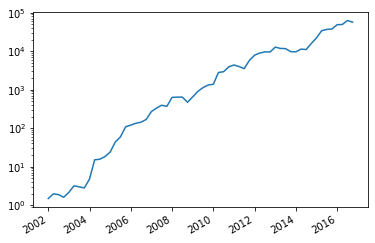

In [33]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot_date(df_account['start_date'], df_account['cum_yield'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [34]:
# 수익률 표준편차 구하기
filetered_yield = df_account['yield'].tolist().copy()

# outlier 제거
filetered_yield.remove(max(filetered_yield))
filetered_yield.remove(min(filetered_yield))

std_yield =  statistics.stdev(filetered_yield)
std_yield

0.27195243056382573

In [35]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_account['cum_yield']:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration

In [36]:
mdd, mdd_duration

(26.462469285874455, 4)

In [37]:
t = PrettyTable(['CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Liquid rate', 'Max market cap', 'Note'])
t.add_row([
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_yield,
           "%.2f%%" % (sum(df_account['delisted']) / (NUM_PORTFOLIO_STOCKS * len(df_account)) * 100.0),
           "%.2f%%" % sum(df_account['yield'] > 1.0),
           LIQUID_RATE,
           MAX_MARKET_CAP,
           ""
          ])
print(t)

+---------+--------+--------------+--------+----------+----------+-------------+----------------+------+
|   CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Liquid rate | Max market cap | Note |
+---------+--------+--------------+--------+----------+----------+-------------+----------------+------+
| 107.44% | 26.46% |      4       | 0.2720 |  1.89%   |  45.00%  |     1.5     |      0.2       |      |
+---------+--------+--------------+--------+----------+----------+-------------+----------------+------+


# 백테스트

- 2002 ~ 2016
- 1/1, 4/1, 7/1, 10/1 리밸런싱

|  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Liquid rate | Max market cap | Note |
|  -  |  -   | - |  -   | - | - | - |-|-|
| 87.84% | 30.88% |      4       | 0.3809 |  1.72%   |  40.00%  |     1.5     |      0.3       |수익률 하위 50     |
| 87.84% | 30.88% |      4       | 0.2836 |  1.72%   |  40.00%  |     1.5     |      0.3       |위 row와 동일 / std 계산 시 min, max 제거      |
| 22.34% | 57.77% |      5       | 0.1625 |  0.61%   |  36.00%  |     1.5     |      0.3       |수익률 상위 50     |
| 55.83% | 35.80% |      4       | 0.2875 |  1.67%   |  41.00%  |     1.5     |      0.5       |수익률 하위 50     |
| 7.89% | 61.11% |      5       | 0.1519 |  0.56%   |  34.00%  |     1.5     |      0.5       |수익률 상위 50      |
| 3.54% | 62.49% |      7       | 0.2668 |  0.17%   |  30.00%  |     1.5     |      0.5 ~ 1       |수익률 하위 50      |
| -0.52% | 65.48% |      8       | 0.2657 |  0.06%   |  28.00%  |     1.5     |      0.7 ~ 1       |수익률 하위 50      |
| -3.17% | 60.31% |      7       | 0.1417 |  0.11%   |  25.00%  |     1.5     |      0.7 ~ 1       |수익률 상위 50      |
| 98.62% | 27.18% |      4       | 0.3692 |  2.00%   |  42.00%  |     1.5     |      0.2       |      |
| 64.65% | 40.30% |      4       | 0.2696 |  1.39%   |  40.00%  |     2.0     |      0.3       |      |
| 55.44% | 39.65% |      3       | 0.2640 |  1.22%   |  42.00%  |     2.0     |      0.4       |      |

- 2002 ~ 2016 리밸런싱 날짜 변화
|  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Liquid rate | Max market cap | Note |
|  -  |  -   | - |  -   | - | - | - |-|-|
| 87.84% | 30.88% |      4       | 0.3809 |  1.72%   |  40.00%  |     1.5     |      0.3       |1/1, 4/1, 7/1, 10/1 리밸런싱     |
| 87.12% | 26.25% |      3       | 0.3404 |  2.11%   |  42.00%  |     1.5     |      0.3       |1/15, 4/15, 7/15, 10/15 리밸런싱     |
| 108.33% | 27.34% |      3       | 0.4652 |  1.78%   |  43.00%  |     1.5     |      0.3       |1/22, 4/22, 7/22, 10/22 리밸런싱      |
| 87.19% | 37.02% |      6       | 0.4135 |  1.72%   |  43.00%  |     1.5     |      0.3       |2/15, 5/15, 8/15, 11/15 리밸런싱      |
| 107.44% | 26.46% |      4       | 0.2720 |  1.89%   |  45.00%  |     1.5     |      0.2       |1, 4, 7, 10 리밸런싱, 과거 60일      |
| 84.69% | 52.47% |      3       | 0.3836 |  1.89%   |  46.00%  |     1.5     |      0.2       |3, 6, 9, 12 리밸런싱, 과거 60일      |
| 64.87% | 45.25% |      4       | 0.2235 |  2.00%   |  42.00%  |     1.5     |      0.2       |2, 5, 8, 11 리밸런싱, 과거 60일      |

- Lookback window size 변화
|  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Liquid rate | Max market cap | Note |
|  -  |  -   | - |  -   | - | - | - |-|-|
| 82.91% | 46.69% |      3       | 0.2333 |  2.06%   |  44.00%  |     1.5     |      0.2       | 365일     |
| 87.76% | 33.02% |      4       | 0.2400 |  2.28%   |  44.00%  |     1.5     |      0.2       | 180일     |
| 98.62% | 27.18% |      4       | 0.2717 |  2.00%   |  42.00%  |     1.5     |      0.2       | 90일     |
| 107.44% | 26.46% |      4       | 0.2720 |  1.89%   |  45.00%  |     1.5     |      0.2       | 60일     |
| 93.56% | 26.25% |      2       | 0.2510 |  1.56%   |  48.00%  |     1.5     |      0.2       | 45일     |
| 83.71% | 32.99% |      2       | 0.2416 |  1.78%   |  47.00%  |     1.5     |      0.2       | 30일     |
| 63.30% | 64.66% |      5       | 0.2726 |  1.83%   |  42.00%  |     1.5     |      0.2       | 60일 ~ 30일     |

# 테스트

- 2017 ~ 2019

|  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Liquid rate | Max market cap | Note |
|  -  |  -   | - |  -   | - | - | - |-|-|
| 8.56% | 20.48% |      2       | 0.1285 |  2.78%   |  8.00%   |     1.5     |      0.2       |      |
| -1.14% | 28.79% |      3       | 0.1445 |  2.78%   |  8.00%   |     1.5     |      0.3       |      |
| 12.96% | 16.39% |      2       | 0.1083 |  3.06%   |  8.00%   |     1.5     |      0.2       | 과거 60일     |
| -5.30% | 27.36% |      4       | 0.0694 |  4.72%   |  6.00%   |     1.5     |      0.2       | 과거 60일, 수익률 높은 상위 30     |

In [18]:
import FinanceDataReader as fdr

kq11 = fdr.DataReader('KQ11', '2002-01-01')

In [162]:
kq_prices = []
for date in df_account['end_date']:
    start_date = date
    end_date = start_date + timedelta(days=5)
    day = kq11[(kq11.index >= str(date)[:10]) & (kq11.index < str(end_date)[:10])]
    kq_prices.append(day.iloc[0].Close)

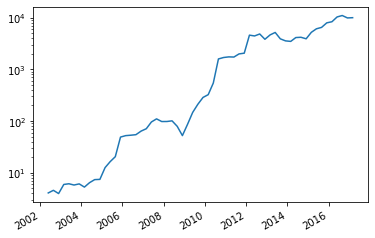

In [163]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot_date(df_account['end_date'], df_account['cum_yield'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

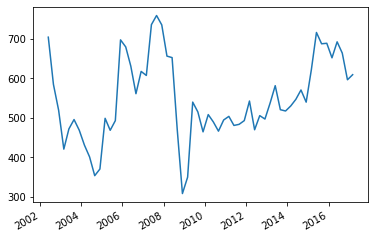

In [164]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.plot_date(df_account['end_date'], kq_prices, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()